In [2]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import customtkinter as ctk
import csv
import tkinter as tk
import cv2
from PIL import Image, ImageTk
import mediapipe as mp
from model import KeyPointClassifier
import itertools
import copy
from datetime import datetime

RANDOM_SEED = 42

# Data Preprocessing

In [ ]:
# tweat train_alph.csv so that it matches coord..csv
df = pd.read_csv("model/keypoint_classifier/Train_Alphabet1.csv")
df = df.sample(5000)
df = df.dropna()
df = df[df['label'].notna() & (df['label'].str.strip() != '')]
df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', 'label'],
      dtype='object')

In [ ]:
# create the mapping dictionary
alphabet_index_map = {chr(i): i - 65 for i in range(65, 91)}  # {'A': 0, 'B': 1', ..., 'Z': 25}
# apply  to df['label']
df['label_index'] = df['label'].map(alphabet_index_map)


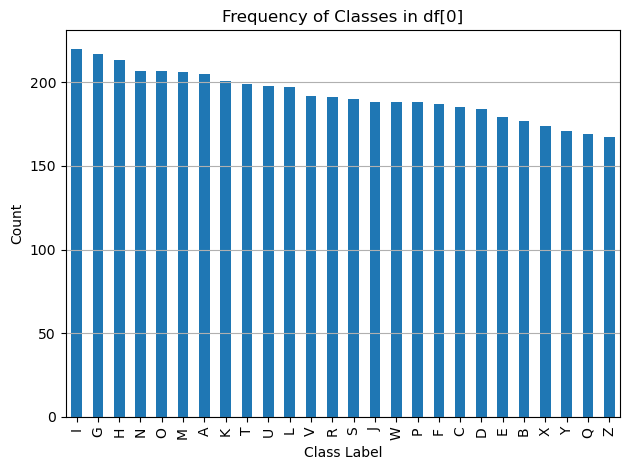

In [205]:
import matplotlib.pyplot as plt
df['label'].value_counts().plot(kind='bar')

plt.title('Frequency of Classes in df[0]')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


/var/folders/nh/b84nc6pd1353r3vmzmt9rxw80000gn/T/ipykernel_77875/370323172.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('label').apply(lambda x: x.sample(n=130, random_state=42)).reset_index(drop=True)


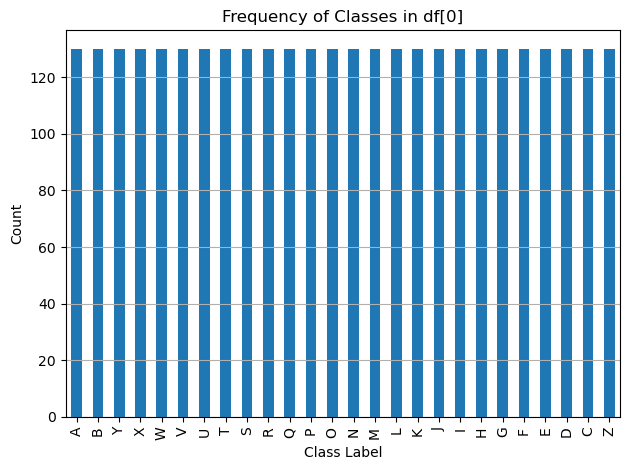

In [ ]:
# balance data
balanced_df = df.groupby('label').apply(lambda x: x.sample(n=130, random_state=42)).reset_index(drop=True)
balanced_df['label'].value_counts().plot(kind='bar')

plt.title('Frequency of Classes in df[0]')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [214]:
# Move 'label' column to the front
df = df[['label_index'] + [col for col in df.columns if col != 'label_index']]
df.columns

Index(['label_index', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58',
       '59', '60', '61', '62', 'label'],
      dtype='object')

In [270]:
df = balanced_df.copy()

In [216]:
df = df.drop(columns=['label'])

In [ ]:
df.head

<bound method NDFrame.head of       label_index         0         1             2         3         4  \
0               0  0.519136  0.812027 -2.922370e-07  0.616423  0.759771   
1               0  0.479245  0.801476 -7.156984e-07  0.559310  0.752633   
2               0  0.490517  0.763605 -7.759800e-07  0.408150  0.720654   
3               0  0.511127  0.826517 -8.370210e-07  0.417574  0.760948   
4               0  0.510511  0.783503 -1.244657e-07  0.607321  0.738031   
...           ...       ...       ...           ...       ...       ...   
3375           25  0.551081  0.860278  7.820580e-08  0.600446  0.816406   
3376           25  0.529863  0.804549  1.666912e-07  0.433340  0.773196   
3377           25  0.560514  0.884036  2.332442e-07  0.616107  0.857451   
3378           25  0.505849  0.911094 -5.571726e-08  0.444266  0.878073   
3379           25  0.526205  0.832042  2.127542e-07  0.574071  0.804206   

             5         6         7         8  ...        54        55

In [217]:
df.to_csv('training.csv', index=False, header=False)


In [ ]:
dataset = 'training.csv'
model_save_path = 'model/keypoint_classifier/asl_model.keras'
tflite_save_path = 'model/keypoint_classifier/model.tflite'

# Actual Model Training
---

In [3]:
import os
import copy
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# CSV_PATH       = "/content/drive/MyDrive/training.csv"
# #MODEL_DIR      = os.path.join("model", "keypoint_classifier")
# MODEL_DIR = "/content/drive/MyDrive"
# MODEL_FILENAME = "asl_model.keras"    
# LABEL_FILENAME = "label.csv"


CSV_PATH       = "/content/training.csv"
MODEL_DIR      = os.path.join("model", "keypoint_classifier")
MODEL_FILENAME = "asl_model.keras"      
LABEL_FILENAME = "label.csv"


os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_FILENAME)
LABEL_PATH = os.path.join(MODEL_DIR, LABEL_FILENAME)

In [4]:
#preprocessing
def pre_process_landmark(landmark_list):
    temp = copy.deepcopy(landmark_list)
    # shift so first landmark is at (0,0)
    base_x, base_y = temp[0][0], temp[0][1]
    for p in temp:
        p[0] -= base_x
        p[1] -= base_y
    flat = list(itertools.chain.from_iterable(temp))
    m = max(map(abs, flat)) or 1.0
    return [v / m for v in flat]

In [5]:
df = pd.read_csv(CSV_PATH, header=None)
df[0] = pd.to_numeric(df[0], errors='coerce')
df = df.dropna(subset=[0])

y_raw = df.iloc[:, 0].astype(int).values           # 0–25
kp_raw = df.iloc[:, 1:].values.astype(np.float32)  # shape (,63)

FileNotFoundError: [Errno 2] No such file or directory: '/content/training.csv'

In [ ]:
# apply same calc_landmark_list + pre_process_landmark 
#   drop z, normalize
processed = []
for row in kp_raw:
    pts = row.reshape(-1, 3)               #(21,3)
    # build landmark_list = [[x,y],…]
    landmark_list = [[x, y] for x, y, z in pts]
    proc = pre_process_landmark(landmark_list)  #  42
    processed.append(proc)
X = np.vstack(processed)  # shape (,42)

le = LabelEncoder()
y = le.fit_transform(y_raw)       
n_classes = len(le.classes_)      # should be 26

letters = [chr(65 + i) for i in range(n_classes)]
with open(LABEL_PATH, "w", encoding="utf-8-sig") as f:
    for L in letters:
        f.write(L + "\n")
print("Wrote labels →", LABEL_PATH)

y_cat = tf.keras.utils.to_categorical(y, n_classes)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y
)

In [ ]:

model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(n_classes, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)


model.save(MODEL_PATH)
print("Trained model saved to", MODEL_PATH)

---


# Alpha cnt

In [276]:
NUM_CLASSES = 26

# Dataset reading

In [277]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [278]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [280]:
print(len(X_test))

845


# Model building

In [281]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((42, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [272]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,192 (35.91 KB)

 Trainable params: 9,192 (35.91 KB)

 Non-trainable params: 0 (0.00 B)

In [259]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=25, verbose=1)

In [273]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model train

In [274]:
import matplotlib.pyplot as plt

history = model.fit(
    X_train,
    y_train,
    epochs=900,
    batch_size=200,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

# Plot train/val loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Epoch 1/900


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_21" is incompatible with the layer: expected axis -1 of input shape to have value 128, but received input with shape (None, 42)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 42), dtype=float32)
  • training=True
  • mask=None

In [269]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4364 - loss: 2.1254 


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 154ms/step
[7.3152198e-04 1.2456423e-10 2.2885220e-02 3.3734581e-03 3.0199146e-08
 1.3165612e-05 3.9126060e-04 8.1487961e-02 1.2231432e-03 4.7883476e-15
 6.4331852e-11 3.9766374e-07 5.3641636e-02 5.7961706e-02 3.2268139e-03
 3.0663386e-01 3.7988904e-01 6.7972427e-04 1.4341011e-03 2.4908180e-08
 5.1495289e-07 6.3423640e-09 5.5545904e-02 3.0880481e-02 2.9974046e-14
 1.5767528e-09 1.0445328e-08]
16


# Conf mat

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


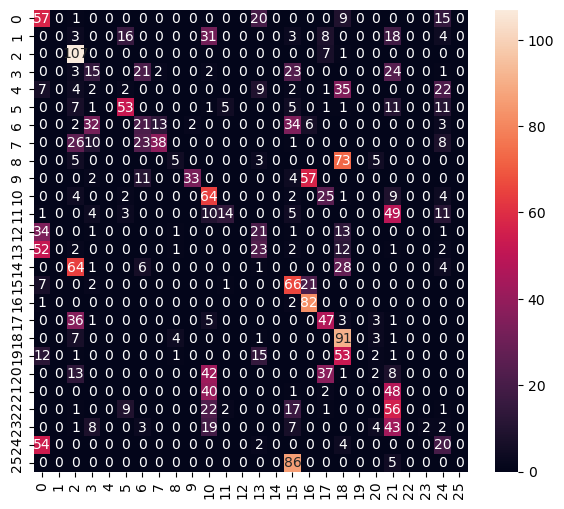

Classification Report
              precision    recall  f1-score   support

           0       0.25      0.56      0.35       102
           1       0.00      0.00      0.00        83
           2       0.37      0.93      0.53       115
           3       0.19      0.16      0.18        91
           4       0.00      0.00      0.00        84
           5       0.62      0.55      0.59        96
           6       0.25      0.19      0.21       113
           7       0.72      0.36      0.48       106
           8       0.42      0.05      0.10        91
           9       0.94      0.31      0.46       107
          10       0.27      0.58      0.37       111
          11       0.64      0.14      0.24        97
          12       0.00      0.00      0.00        72
          13       0.24      0.24      0.24        95
          14       0.00      0.00      0.00       104
          15       0.25      0.68      0.37        97
          16       0.49      0.96      0.65        85
     

/opt/anaconda3/envs/handsign-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/handsign-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/handsign-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [142]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Users\Tirth Kothari\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Tirth Kothari\AppData\Local\Temp\tmpbqy8bb60\assets


INFO:tensorflow:Assets written to: C:\Users\Tirth Kothari\AppData\Local\Temp\tmpbqy8bb60\assets


7556

# error solve

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.3152198e-04 1.2456398e-10 2.2885226e-02 3.3734578e-03 3.0199093e-08
 1.3165598e-05 3.9126043e-04 8.1488028e-02 1.2231419e-03 4.7883471e-15
 6.4331734e-11 3.9766257e-07 5.3641632e-02 5.7961661e-02 3.2268136e-03
 3.0663398e-01 3.7988904e-01 6.7972357e-04 1.4340992e-03 2.4908129e-08
 5.1495283e-07 6.3423391e-09 5.5545837e-02 3.0880507e-02 2.9974046e-14
 1.5767528e-09 1.0445308e-08]
16
